In [2]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
import Template
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(os.path.dirname(os.getcwd()), '..', 'Datos1_InteraccionesNIR.xlsx')


In [3]:
# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Datos1_InteraccionesNIR.xlsx')
# import the data from all sheets of the Excel file

df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(16)
]


df = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], ignore_index=True)

print(df['Tratamiento'].value_counts())

Tratamiento
E_Hidrico     478
Control       461
Fusarium      448
Fus_EH_Ral    440
Ral_EH        436
Fus_EH        432
Ralstonia     428
Ral_Fus       412
Name: count, dtype: int64


In [4]:
# If the dataframes have any missing values on the 'Tratamiento' column, delete those rows
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15]):
    if df['Tratamiento'].isnull().any():
        df.dropna(subset=['Tratamiento'], inplace=True)
        print(f"Dropped missing 'Tratamiento' rows in df{i}")

Dropped missing 'Tratamiento' rows in df4
Dropped missing 'Tratamiento' rows in df10


In [5]:
# Lets add the column 'Sana' to all dataframes
for i, df in enumerate([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], start=0):
    # Index plants within each 'Tratamiento' category (starting from 1 for each category)
    if 'Planta' not in df.columns:
        plant_numbers = []
        for tratamiento in df['Tratamiento'].unique():
            category_mask = df['Tratamiento'] == tratamiento
            n_plants_in_category = category_mask.sum()
            # Create plant numbers from 1 to n for this category
            plant_numbers_for_category = list(range(1, n_plants_in_category + 1))
            
            # Add plant numbers in the correct order matching the dataframe rows
            for idx in df[category_mask].index:
                plant_numbers.append(plant_numbers_for_category.pop(0))
        
        df.insert(1, 'Planta', plant_numbers)
        print(f"df{i}: Added 'Planta' column by 'Tratamiento' categories")
        for tratamiento in df['Tratamiento'].unique():
            count = sum(df['Tratamiento'] == tratamiento)
            print(f"  {tratamiento}: {count} plants")
    
    # Now add 'Sana' and drop 'Tratamiento'
    df.insert(1, 'Sana', df['Tratamiento'].apply(lambda x: 1 if x == 'Control' else 0))


df0: Added 'Planta' column by 'Tratamiento' categories
  Control: 29 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 27 plants
  Ral_EH: 30 plants
  Fus_EH_Ral: 30 plants
df1: Added 'Planta' column by 'Tratamiento' categories
  Control: 30 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 30 plants
  Ral_EH: 30 plants
  Fus_EH: 30 plants
  Fus_EH_Ral: 30 plants
df2: Added 'Planta' column by 'Tratamiento' categories
  Control: 28 plants
  Ralstonia: 29 plants
  Fusarium: 29 plants
  E_Hidrico: 28 plants
  Ral_Fus: 29 plants
  Ral_EH: 30 plants
  Fus_EH: 30 plants
  Fus_EH_Ral: 30 plants
df3: Added 'Planta' column by 'Tratamiento' categories
  Control: 30 plants
  Ralstonia: 29 plants
  Fusarium: 30 plants
  E_Hidrico: 30 plants
  Ral_Fus: 30 plants
  Ral_EH: 30 plants
  Fus_EH: 28 plants
  Fus_EH_Ral: 30 plants
df4: Added 'Planta' column by 'Tratamiento' categories
  Control: 29 plants
  Ralstonia: 29 plants
  Fus

In [6]:
# Import PCA_Analysis class from PCA_template.py in the current directory
sys.path.insert(0, str(Path.cwd()))
from PCA_template import PCA_Analysis

## PCA by day

In [7]:
df1.head()  # Display the first few rows to verify changes

,Tratamiento,Sana,Planta,350,351,352,353,354,355,356,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,Control,1,1,0.078084,0.075299,0.077410,0.074002,0.070505,0.067700,0.062893,...,0.036214,0.036081,0.035957,0.035807,0.035688,0.035551,0.035364,0.035257,0.035179,0.035142
1,Control,1,2,0.073550,0.067523,0.071681,0.067482,0.063859,0.062469,0.059024,...,0.033057,0.032865,0.032683,0.032480,0.032208,0.032009,0.031834,0.031691,0.031569,0.031492
2,Control,1,3,0.078702,0.072332,0.076551,0.075096,0.069730,0.063826,0.060950,...,0.032032,0.031893,0.031702,0.031533,0.031349,0.031142,0.030905,0.030750,0.030586,0.030511
3,Control,1,4,0.068565,0.067309,0.070531,0.066035,0.062364,0.060529,0.055741,...,0.031268,0.031147,0.030997,0.030795,0.030522,0.030354,0.030158,0.030026,0.030024,0.029915
4,Control,1,5,0.070898,0.067701,0.075494,0.069948,0.063975,0.061855,0.060048,...,0.029287,0.029146,0.029101,0.028976,0.028791,0.028641,0.028453,0.028389,0.028404,0.028371


### Day 1

Explained variance by PC1: 62.87%
Explained variance by PC2: 21.20%
Total explained variance: 84.07%


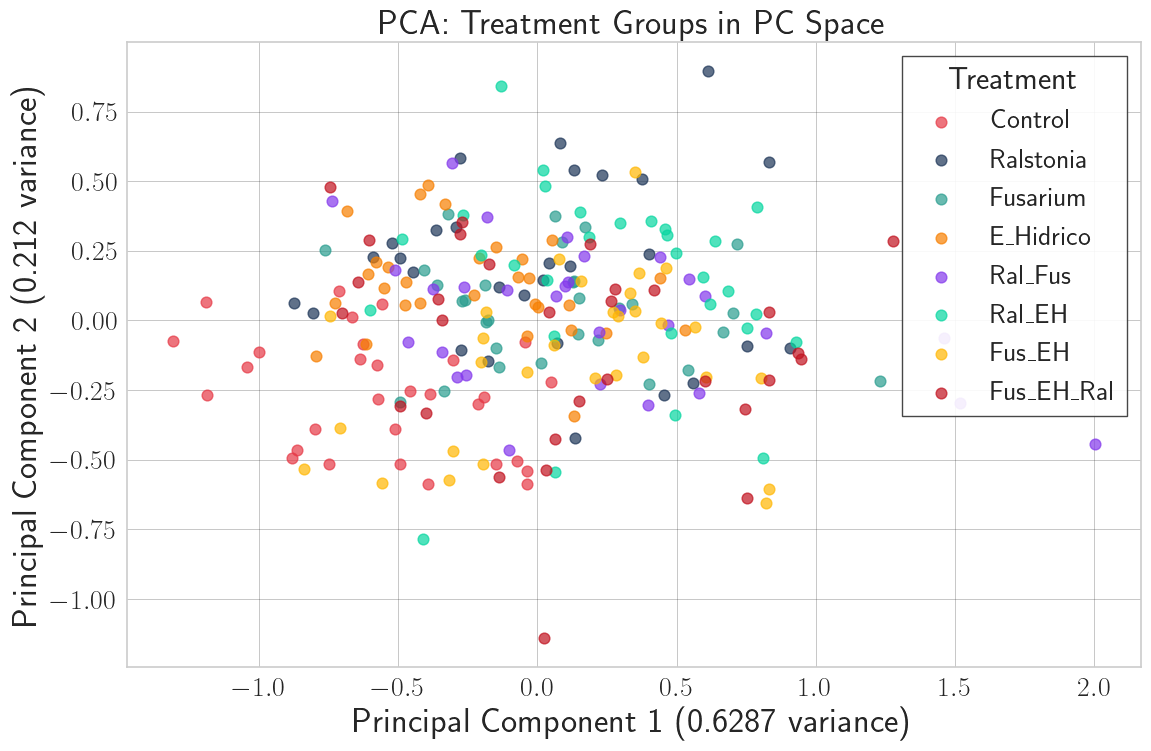

In [8]:
pca_analysis = PCA_Analysis(df1)
pca_results = pca_analysis.PCA_2D()

Explained variance by PC1: 62.87%
Explained variance by PC2: 21.20%
Explained variance by PC3: 5.74%
Total explained variance: 89.81%


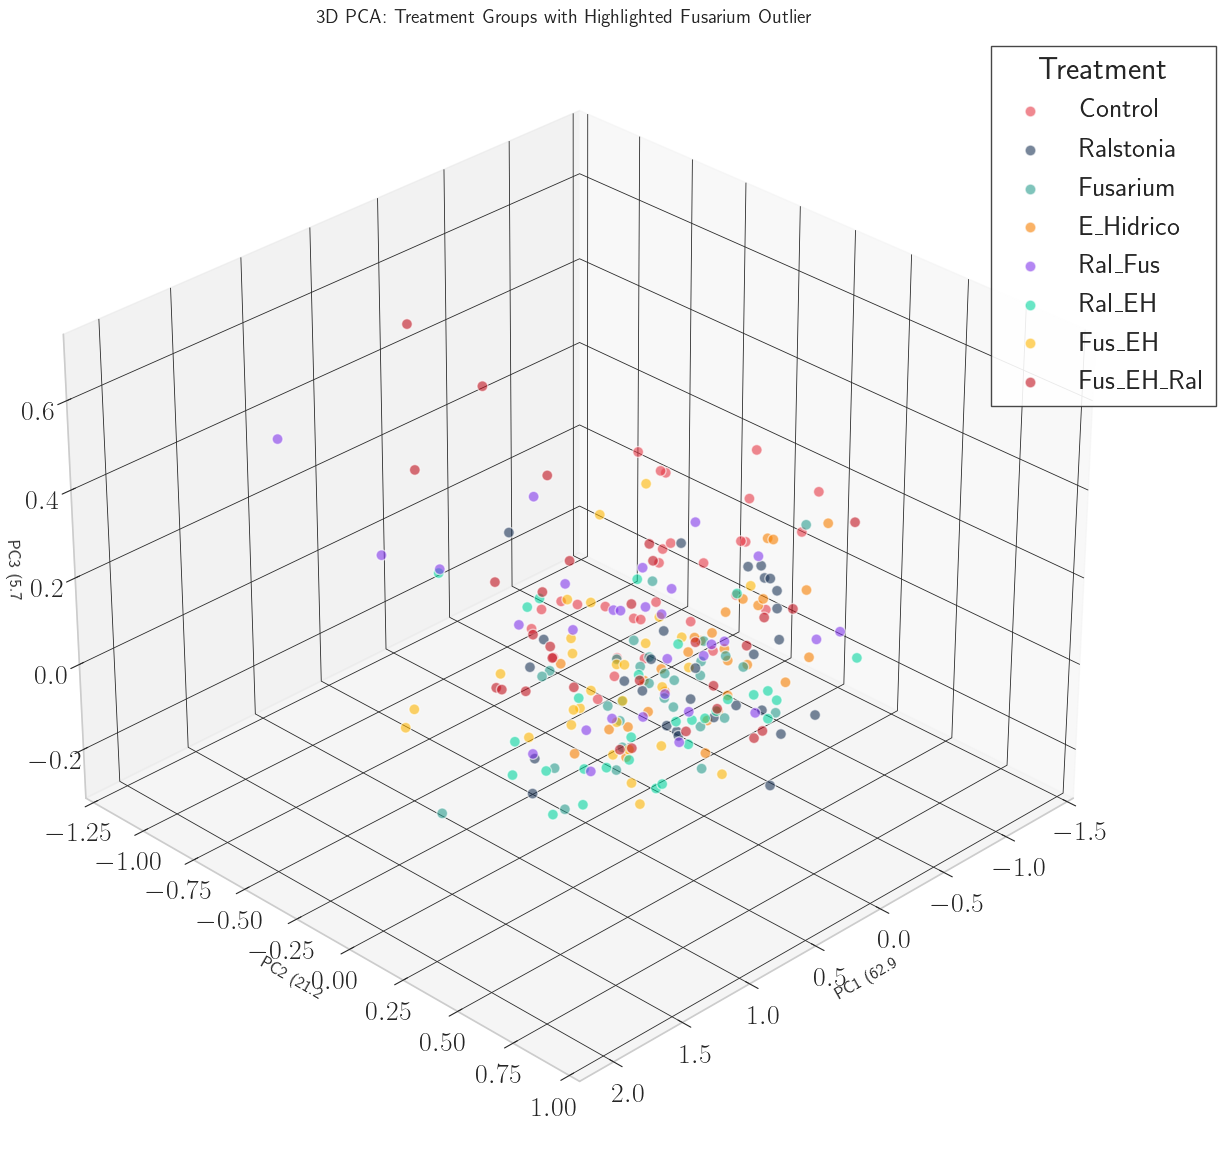

In [9]:
pca_analysis = PCA_Analysis(df1)
pca_results = pca_analysis.PCA_3D()

### Day 2

Explained variance by PC1: 84.89%
Explained variance by PC2: 10.64%
Total explained variance: 95.53%


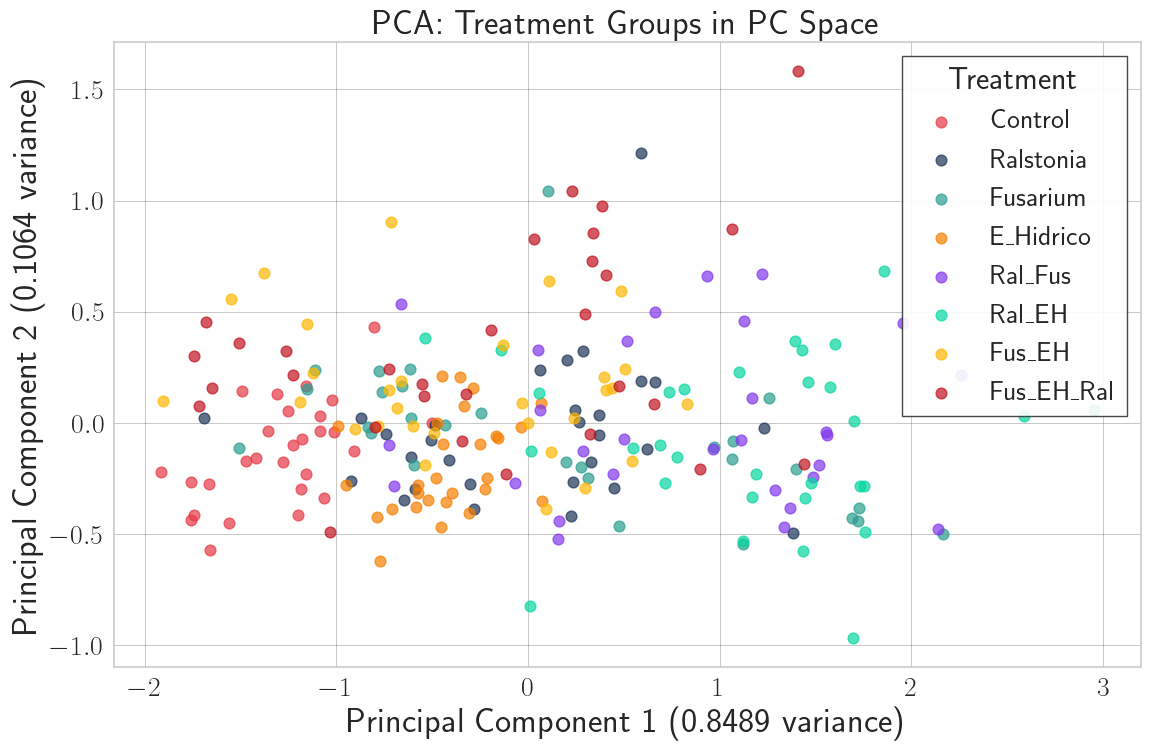

In [10]:
pca_analysis = PCA_Analysis(df2)
pca_results = pca_analysis.PCA_2D()

Explained variance by PC1: 84.89%
Explained variance by PC2: 10.64%
Explained variance by PC3: 1.90%
Total explained variance: 97.42%


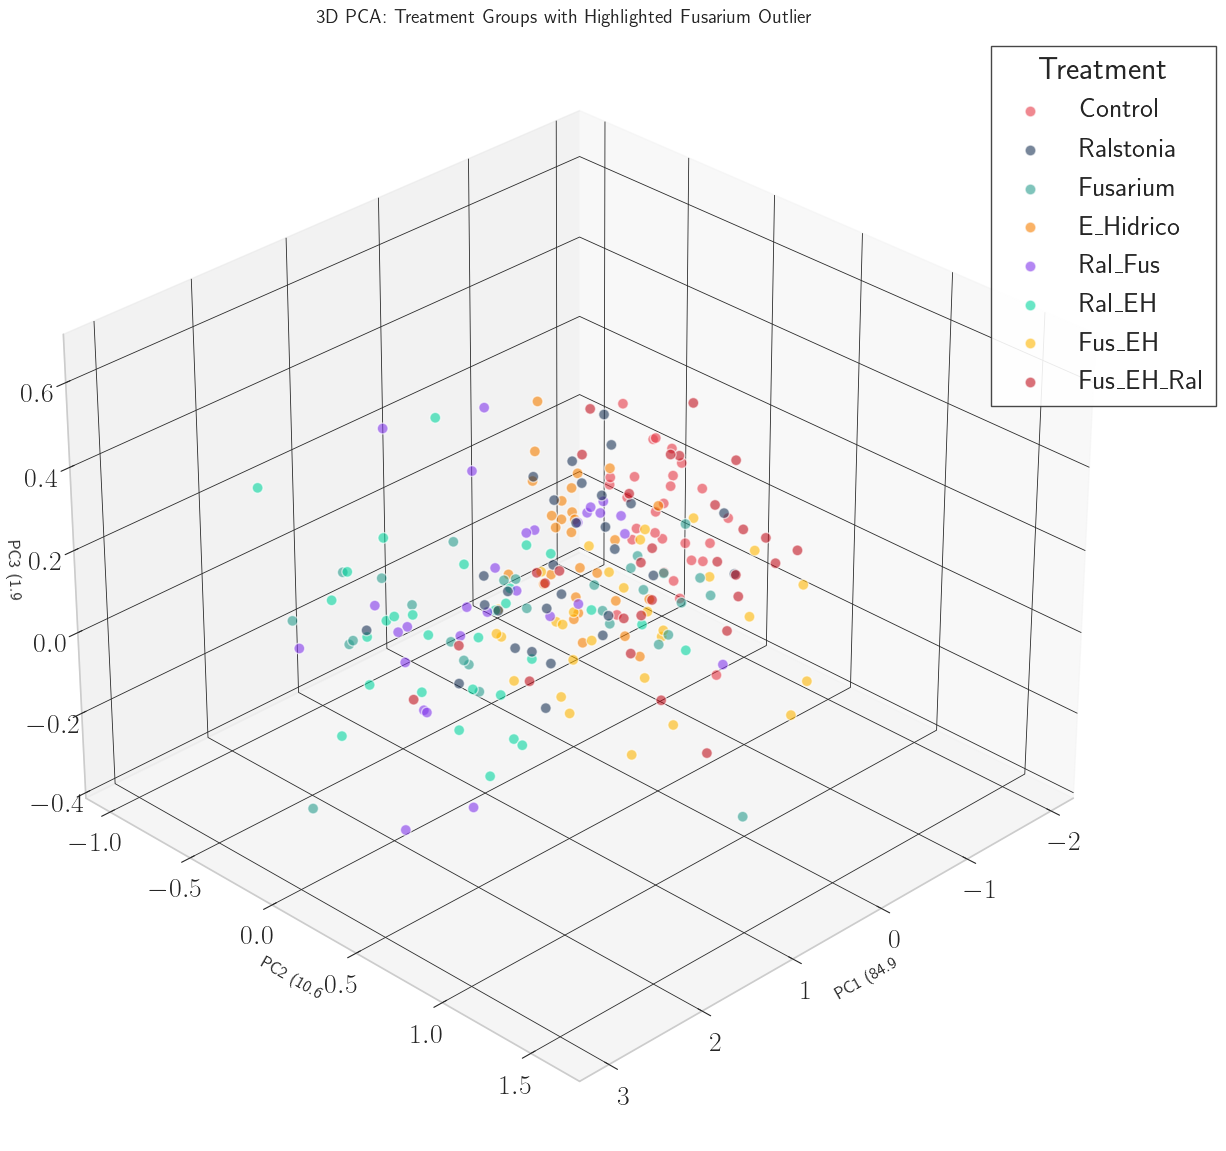

In [11]:
pca_analysis = PCA_Analysis(df2)
pca_results = pca_analysis.PCA_3D()

### Day 3

Explained variance by PC1: 68.02%
Explained variance by PC2: 19.54%
Total explained variance: 87.56%


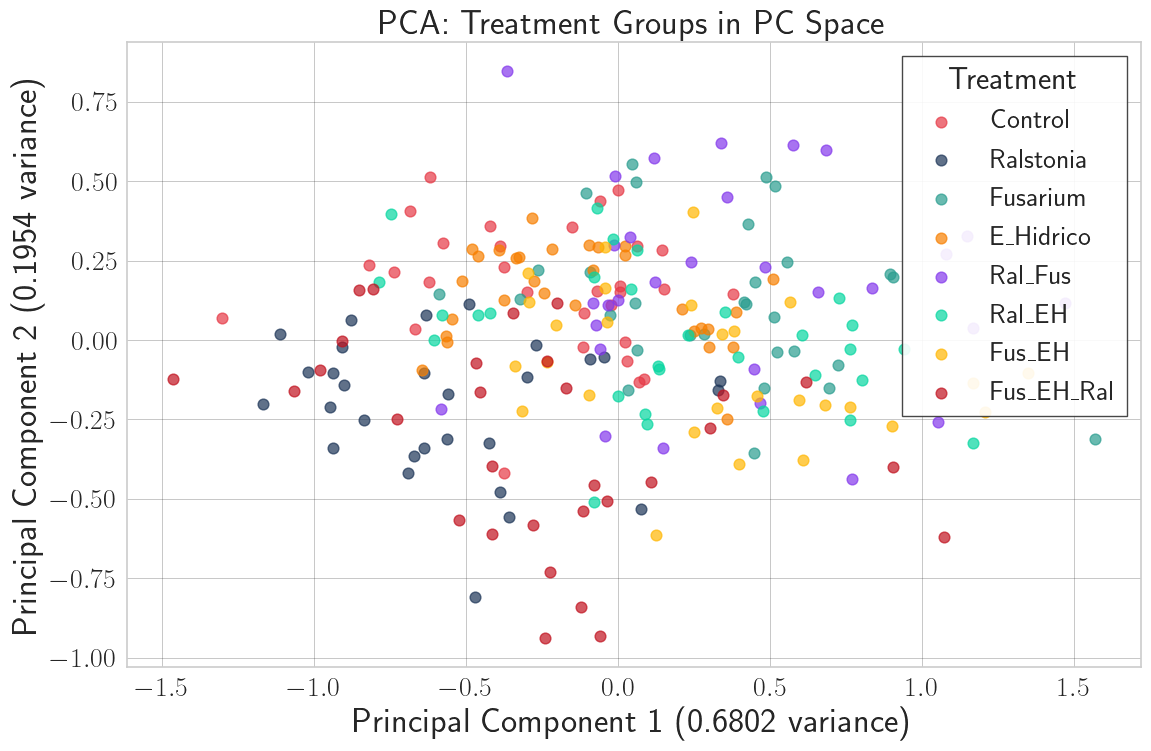

In [12]:
pca_analysis = PCA_Analysis(df3)
pca_results = pca_analysis.PCA_2D()

Explained variance by PC1: 68.02%
Explained variance by PC2: 19.54%
Explained variance by PC3: 4.21%
Total explained variance: 91.77%


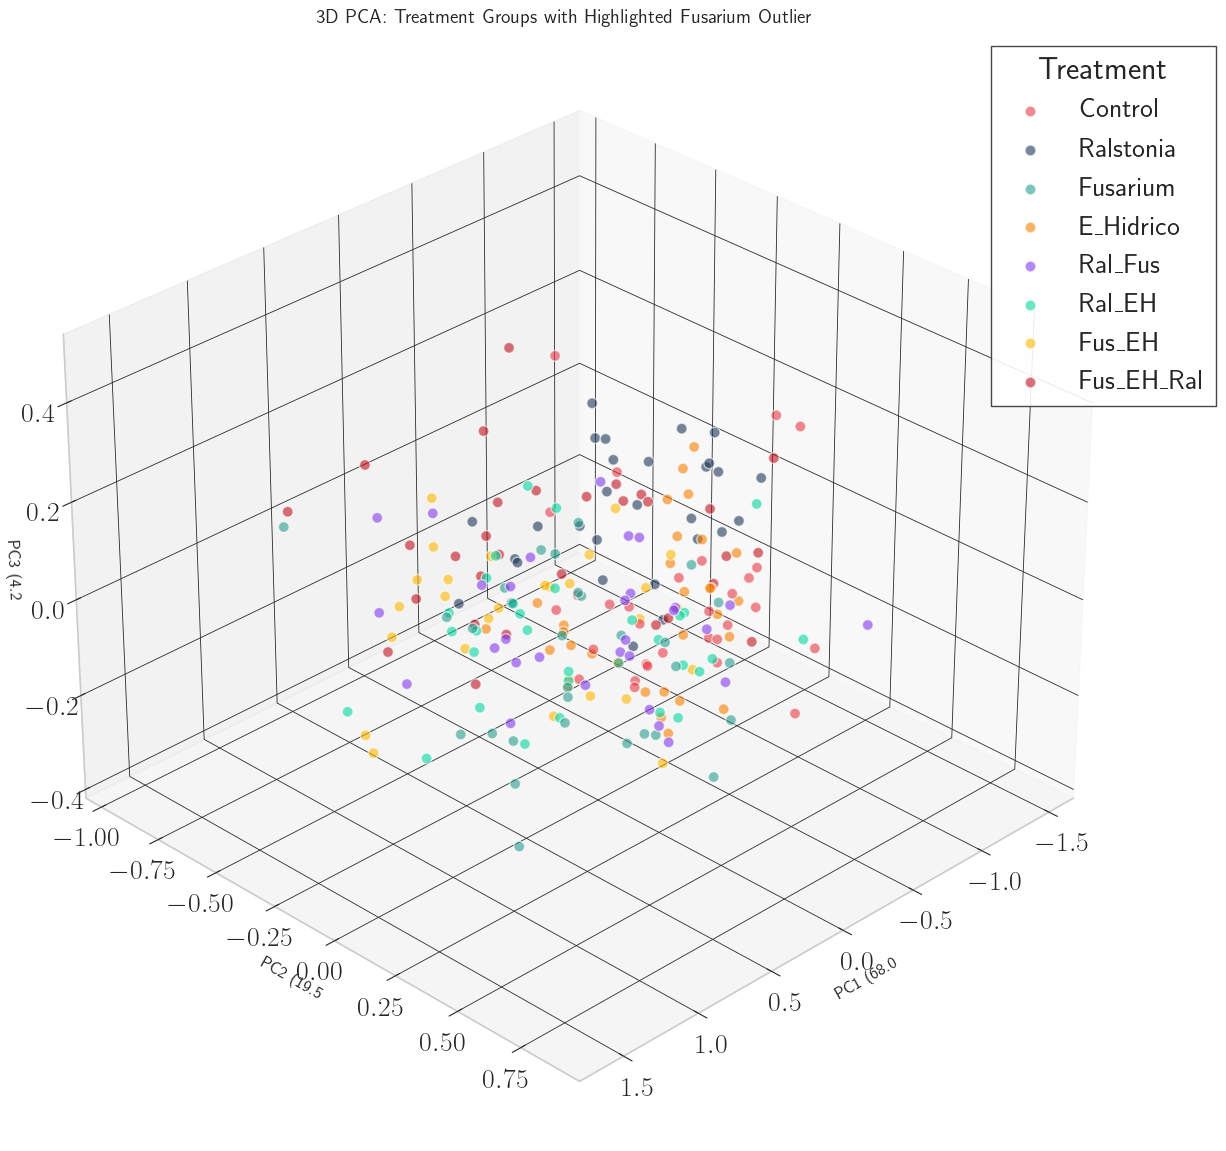

In [13]:
pca_analysis = PCA_Analysis(df3)
pca_results = pca_analysis.PCA_3D()

## Day 7

Explained variance by PC1: 66.34%
Explained variance by PC2: 30.42%
Total explained variance: 96.75%


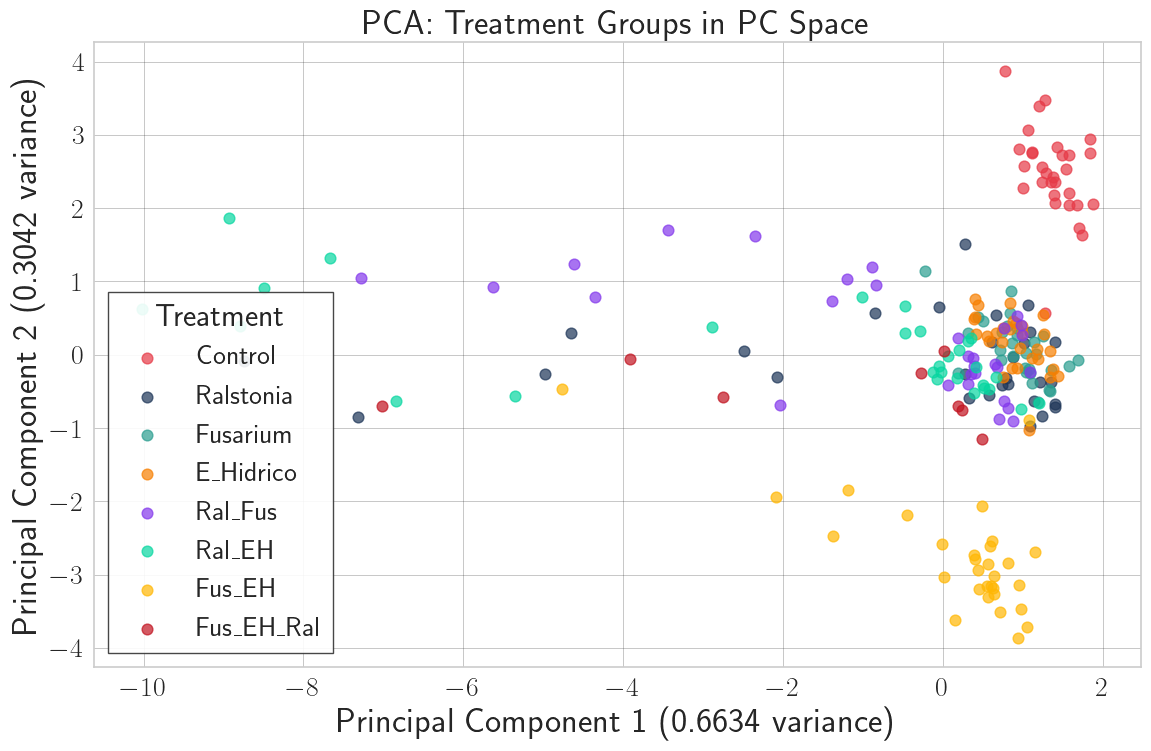

In [14]:
pca_analysis = PCA_Analysis(df7)
pca_results = pca_analysis.PCA_2D()

## PCA by treatment

### Control

In [ ]:
print('--- PCA Control Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Control']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Control']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Control']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Control Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Control Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Control Day 3', color='red')
plt.title('PCA of Control Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()


In [9]:
print('--- PCA Control Samples Across All Days ---')
print('---')

# Create lists to store PCA results for each day
pca_control_list = []
day_labels = []

# Process all dataframes (df1 through df15)
dataframes = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15]

for i, df in enumerate(dataframes, start=1):
    print(f'PCA df{i}')
    
    # Perform PCA
    pca_analysis = PCA_Analysis(df)
    pca_results = pca_analysis.PCA_3D_noplot()
    
    # Extract control samples
    pca_control = pca_results[pca_results['Tratamiento'] == 'Control']
    
    if not pca_control.empty:
        pca_control_list.append(pca_control)
        day_labels.append(f'Control Day {i}')
    
    print('---')

# 3D plot with all control samples
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Use a colormap for distinguishing days
colors = plt.cm.tab20(np.linspace(0, 1, len(pca_control_list)))

for pca_data, label, color in zip(pca_control_list, day_labels, colors):
    ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], 
              label=label, alpha=0.6, s=50)

ax.set_title('PCA of Control Samples Across All Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid()
plt.tight_layout()
plt.show()

# 2D projections plot
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

for pca_data, label, color in zip(pca_control_list, day_labels, colors):
    # PC1 vs PC2
    axs[0].scatter(pca_data['PC1'], pca_data['PC2'], label=label, 
                   alpha=0.6, s=50, color=color)
    # PC1 vs PC3
    axs[1].scatter(pca_data['PC1'], pca_data['PC3'], label=label, 
                   alpha=0.6, s=50, color=color)
    # PC2 vs PC3
    axs[2].scatter(pca_data['PC2'], pca_data['PC3'], label=label, 
                   alpha=0.6, s=50, color=color)

axs[0].set_title('PC1 vs PC2', fontsize=12)
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].grid(True, alpha=0.3)

axs[1].set_title('PC1 vs PC3', fontsize=12)
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC3')
axs[1].grid(True, alpha=0.3)

axs[2].set_title('PC2 vs PC3', fontsize=12)
axs[2].set_xlabel('PC2')
axs[2].set_ylabel('PC3')
axs[2].grid(True, alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


--- PCA Control Samples Across All Days ---
---
PCA df1
Explained variance by PC1: 62.56%
Explained variance by PC2: 21.24%
Explained variance by PC3: 5.96%
Total explained variance: 89.77%


KeyError: 'Tratamiento'

### Fusarium

In [ ]:
print('--- PCA Fusarium Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fusarium']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fusarium']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fusarium']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fusarium Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fusarium Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fusarium Day 3', color='red')
plt.title('PCA of Fusarium Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('--- PCA Fusarium Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fusarium']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fusarium']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fusarium']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='Fusarium Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='Fusarium Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='Fusarium Day 3', color='red')
ax.set_title('PCA of Fusarium Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fusarium Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fusarium Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fusarium Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='Fusarium Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='Fusarium Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='Fusarium Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='Fusarium Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='Fusarium Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='Fusarium Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Ralstonia

In [ ]:
print('--- PCA Ralstonia Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ralstonia']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ralstonia']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ralstonia']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ralstonia Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ralstonia Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ralstonia Day 3', color='red')
plt.title('PCA of Ralstonia Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('--- PCA Ralstonia Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ralstonia']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ralstonia']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ralstonia']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='Ralstonia Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='Ralstonia Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='Ralstonia Day 3', color='red')
ax.set_title('PCA of Ralstonia Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ralstonia Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ralstonia Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ralstonia Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='Ralstonia Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='Ralstonia Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='Ralstonia Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='Ralstonia Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='Ralstonia Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='Ralstonia Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Estres Hidrico

In [ ]:
print('--- PCA E_Hidrico Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'E_Hidrico']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'E_Hidrico']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'E_Hidrico']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='E_Hidrico Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='E_Hidrico Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='E_Hidrico Day 3', color='red')
plt.title('PCA of E_Hidrico Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('--- PCA E_Hidrico Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'E_Hidrico']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'E_Hidrico']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'E_Hidrico']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='E_Hidrico Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='E_Hidrico Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='E_Hidrico Day 3', color='red')
ax.set_title('PCA of E_Hidrico Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='E_Hidrico Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='E_Hidrico Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='E_Hidrico Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='E_Hidrico Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='E_Hidrico Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='E_Hidrico Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='E_Hidrico Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='E_Hidrico Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='E_Hidrico Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Ral_EH

In [ ]:
print('--- PCA Ral_EH Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ral_EH']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ral_EH']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ral_EH']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ral_EH Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ral_EH Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ral_EH Day 3', color='red')
plt.title('PCA of Ral_EH Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('--- PCA Ral_EH Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ral_EH']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ral_EH']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ral_EH']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='Ral_EH Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='Ral_EH Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='Ral_EH Day 3', color='red')
ax.set_title('PCA of Ral_EH Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ral_EH Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ral_EH Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ral_EH Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='Ral_EH Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='Ral_EH Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='Ral_EH Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='Ral_EH Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='Ral_EH Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='Ral_EH Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Ral_Fus

In [ ]:
print('--- PCA Ral_Fus Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ral_Fus']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ral_Fus']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ral_Fus']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ral_Fus Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ral_Fus Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ral_Fus Day 3', color='red')
plt.title('PCA of Ral_Fus Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('--- PCA Ral_Fus Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Ral_Fus']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Ral_Fus']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Ral_Fus']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='Ral_Fus Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='Ral_Fus Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='Ral_Fus Day 3', color='red')
ax.set_title('PCA of Ral_Fus Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Ral_Fus Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Ral_Fus Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Ral_Fus Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='Ral_Fus Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='Ral_Fus Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='Ral_Fus Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='Ral_Fus Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='Ral_Fus Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='Ral_Fus Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Fus_EH_Ral 

In [ ]:
print('--- PCA Fus_EH_Ral Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fus_EH_Ral']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fus_EH_Ral']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fus_EH_Ral']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fus_EH_Ral Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fus_EH_Ral Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fus_EH_Ral Day 3', color='red')
plt.title('PCA of Fus_EH_Ral Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('--- PCA Fus_EH_Ral Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fus_EH_Ral']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fus_EH_Ral']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fus_EH_Ral']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='Fus_EH_Ral Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='Fus_EH_Ral Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='Fus_EH_Ral Day 3', color='red')
ax.set_title('PCA of Fus_EH_Ral Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fus_EH_Ral Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fus_EH_Ral Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fus_EH_Ral Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='Fus_EH_Ral Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='Fus_EH_Ral Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='Fus_EH_Ral Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='Fus_EH_Ral Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='Fus_EH_Ral Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='Fus_EH_Ral Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

### Fus_EH

In [ ]:
print('--- PCA Fus_EH Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_2D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fus_EH']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_2D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fus_EH']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_2D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fus_EH']

print('---')

# Now plot all control samples together
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fus_EH Day 1', color='blue')
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fus_EH Day 2', color='green')
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fus_EH Day 3', color='red')
plt.title('PCA of Fus_EH Samples Across Days')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('--- PCA Fus_EH Samples Across Days ---')
print('---')
print('PCA df1 ')

# Day 1
pca_1 = PCA_Analysis(df1)
pca_results_1 = pca_1.PCA_3D_noplot()

# extract control samples
pca_control_1 = pca_results_1[pca_results_1['Tratamiento'] == 'Fus_EH']

print('---')

print('PCA df2 ')
# Day 2
pca_2 = PCA_Analysis(df2)
pca_results_2 = pca_2.PCA_3D_noplot()

# extract control samples
pca_control_2 = pca_results_2[pca_results_2['Tratamiento'] == 'Fus_EH']

print('---')

print('PCA df3 ')
# Day 3
pca_3 = PCA_Analysis(df3)
pca_results_3 = pca_3.PCA_3D_noplot()

# extract control samples
pca_control_3 = pca_results_3[pca_results_3['Tratamiento'] == 'Fus_EH']

print('---')

# Now plot all control samples together
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_control_1['PC1'], pca_control_1['PC2'], pca_control_1['PC3'], label='Fus_EH Day 1', color='blue')
ax.scatter(pca_control_2['PC1'], pca_control_2['PC2'], pca_control_2['PC3'], label='Fus_EH Day 2', color='green')
ax.scatter(pca_control_3['PC1'], pca_control_3['PC2'], pca_control_3['PC3'], label='Fus_EH Day 3', color='red')
ax.set_title('PCA of Fus_EH Samples Across Days')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend()
plt.grid()
plt.show()

# lets plot some projections over PC1-PC2, PC1-PC3, PC2-PC3 planes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# PC1 vs PC2
sns.scatterplot(data=pca_control_1, x='PC1', y='PC2', label='Fus_EH Day 1', color='blue', ax=axs[0])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC2', label='Fus_EH Day 2', color='green', ax=axs[0])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC2', label='Fus_EH Day 3', color='red', ax=axs[0])
axs[0].set_title('PC1 vs PC2')
# PC1 vs PC3
sns.scatterplot(data=pca_control_1, x='PC1', y='PC3', label='Fus_EH Day 1', color='blue', ax=axs[1])
sns.scatterplot(data=pca_control_2, x='PC1', y='PC3', label='Fus_EH Day 2', color='green', ax=axs[1])
sns.scatterplot(data=pca_control_3, x='PC1', y='PC3', label='Fus_EH Day 3', color='red', ax=axs[1])
axs[1].set_title('PC1 vs PC3')
# PC2 vs PC3
sns.scatterplot(data=pca_control_1, x='PC2', y='PC3', label='Fus_EH Day 1', color='blue', ax=axs[2])
sns.scatterplot(data=pca_control_2, x='PC2', y='PC3', label='Fus_EH Day 2', color='green', ax=axs[2])
sns.scatterplot(data=pca_control_3, x='PC2', y='PC3', label='Fus_EH Day 3', color='red', ax=axs[2])
axs[2].set_title('PC2 vs PC3')
plt.legend()
plt.grid()
plt.show()

## Wavelength decomposition by PCA

## Day 1

In [ ]:
# Correct PCA implementation
pca = PCA(n_components=2)


wavelength_data = df1.iloc[:, 3:]

pca_results = pca.fit_transform(wavelength_data)


In [ ]:
# Get the loadings for the first two principal components
loadings = pca.components_

# Create x-axis values (wavelengths)
wavelengths = [int(col) for col in wavelength_data.columns]

# Create a plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot loadings for PC1 and PC2
ax.plot(wavelengths, loadings[0, :], label=f'PC1 ({pca.explained_variance_ratio_[0]:.2f} variance)', linewidth=2.5)
ax.plot(wavelengths, loadings[1, :], label=f'PC2 ({pca.explained_variance_ratio_[1]:.2f} variance)', linewidth=2.5)

# Add labels and title
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('Loading value', fontsize=12)
ax.set_title('PCA Loadings - Spectral Regions Contributing to Principal Components', fontsize=14)

# Add a horizontal line at y=0 for reference
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Add shaded regions for different spectral ranges
ax.axvspan(350, 700, alpha=0.1, color='purple', label='Visible')
ax.axvspan(700, 1100, alpha=0.1, color='red', label='NIR 1')
ax.axvspan(1100, 1800, alpha=0.1, color='green', label='NIR 2')
ax.axvspan(1800, 2500, alpha=0.1, color='blue', label='NIR 3')

# Create custom legends
# First legend for PC1 and PC2
handles1, labels1 = ax.get_legend_handles_labels()
leg1 = ax.legend(handles1[:2], labels1[:2], loc='upper right', fontsize=10)
ax.add_artist(leg1)

# Second legend for spectral regions
handles2, labels2 = ax.get_legend_handles_labels()
ax.legend(handles2[2:], labels2[2:], loc='upper left', fontsize=10)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Day 2

In [ ]:
pca = PCA(n_components=2)

wavelength_data = df2.iloc[:, 3:]

pca_results = pca.fit_transform(wavelength_data)

In [ ]:
# Get the loadings for the first two principal components
loadings = pca.components_

# Create x-axis values (wavelengths)
wavelengths = [int(col) for col in wavelength_data.columns]

# Create a plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot loadings for PC1 and PC2
ax.plot(wavelengths, loadings[0, :], label=f'PC1 ({pca.explained_variance_ratio_[0]:.2f} variance)', linewidth=2.5)
ax.plot(wavelengths, loadings[1, :], label=f'PC2 ({pca.explained_variance_ratio_[1]:.2f} variance)', linewidth=2.5)

# Add labels and title
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('Loading value', fontsize=12)
ax.set_title('PCA Loadings - Spectral Regions Contributing to Principal Components', fontsize=14)

# Add a horizontal line at y=0 for reference
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Add shaded regions for different spectral ranges
ax.axvspan(350, 700, alpha=0.1, color='purple', label='Visible')
ax.axvspan(700, 1100, alpha=0.1, color='red', label='NIR 1')
ax.axvspan(1100, 1800, alpha=0.1, color='green', label='NIR 2')
ax.axvspan(1800, 2500, alpha=0.1, color='blue', label='NIR 3')

# Create custom legends
# First legend for PC1 and PC2
handles1, labels1 = ax.get_legend_handles_labels()
leg1 = ax.legend(handles1[:2], labels1[:2], loc='upper right', fontsize=10)
ax.add_artist(leg1)

# Second legend for spectral regions
handles2, labels2 = ax.get_legend_handles_labels()
ax.legend(handles2[2:], labels2[2:], loc='upper left', fontsize=10)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Day 3

In [ ]:
pca = PCA(n_components=2)

wavelength_data = df3.iloc[:, 3:]

pca_results = pca.fit_transform(wavelength_data)

In [ ]:
# Get the loadings for the first two principal components
loadings = pca.components_

# Create x-axis values (wavelengths)
wavelengths = [int(col) for col in wavelength_data.columns]

# Create a plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot loadings for PC1 and PC2
ax.plot(wavelengths, loadings[0, :], label=f'PC1 ({pca.explained_variance_ratio_[0]:.2f} variance)', linewidth=2.5)
ax.plot(wavelengths, loadings[1, :], label=f'PC2 ({pca.explained_variance_ratio_[1]:.2f} variance)', linewidth=2.5)

# Add labels and title
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('Loading value', fontsize=12)
ax.set_title('PCA Loadings - Spectral Regions Contributing to Principal Components', fontsize=14)

# Add a horizontal line at y=0 for reference
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Add shaded regions for different spectral ranges
ax.axvspan(350, 700, alpha=0.1, color='purple', label='Visible')
ax.axvspan(700, 1100, alpha=0.1, color='red', label='NIR 1')
ax.axvspan(1100, 1800, alpha=0.1, color='green', label='NIR 2')
ax.axvspan(1800, 2500, alpha=0.1, color='blue', label='NIR 3')

# Create custom legends
# First legend for PC1 and PC2
handles1, labels1 = ax.get_legend_handles_labels()
leg1 = ax.legend(handles1[:2], labels1[:2], loc='upper right', fontsize=10)
ax.add_artist(leg1)

# Second legend for spectral regions
handles2, labels2 = ax.get_legend_handles_labels()
ax.legend(handles2[2:], labels2[2:], loc='upper left', fontsize=10)

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()